## **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## **Data Configuration and Loading**

In [ ]:
# Data Configuration and Loading
batch_size = 250
transform_pipeline = transforms.Compose([transforms.ToTensor()])

training_dataset = datasets.MNIST(root="./data", train=True, transform=transform_pipeline, download=True)
testing_dataset = datasets.MNIST(root="./data", train=False, transform=transform_pipeline, download=True)

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.10MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## **Model Definition: Variational Autoencoder**

In [ ]:
# Variational Autoencoder Model Definition
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dimension=28*28, hidden_size=512, latent_size=2):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dimension, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.SiLU(),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, 2 * latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 4),
            nn.SiLU(),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, input_dimension),
            nn.Sigmoid()
        )

    def encode(self, x, eps=1e-8):
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=-1)
        std = (0.5 * logvar).exp() + eps
        return mu, std

    def reparameterize(self, mu, std):
        noise = torch.randn_like(std)
        return mu + noise * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, std = self.encode(x)
        z = self.reparameterize(mu, std)
        reconstruction = self.decode(z)
        return reconstruction, mu, std

## **Training Function**

In [ ]:
# Training Function for the VAE
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-3, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    fixed_noise_sample = torch.randn(16, model.decoder[0].in_features).to(device)

    epochs_to_visualize = [1, 50, 100]
    generated_images_dict = {}
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs, _ = batch
            inputs = inputs.view(inputs.size(0), -1).to(device)

            reconstruction, mu, std = model(inputs)

            bce_loss = F.binary_cross_entropy(reconstruction, inputs, reduction="sum")
            kl_divergence = -0.5 * torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
            loss = (bce_loss + kl_divergence) / inputs.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss_history.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, _ = batch
                inputs = inputs.view(inputs.size(0), -1).to(device)
                reconstruction, mu, std = model(inputs)
                bce_loss = F.binary_cross_entropy(reconstruction, inputs, reduction="sum")
                kl_divergence = -0.5 * torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
                total_val_loss += (bce_loss + kl_divergence).item()
            val_loss_history.append(total_val_loss / len(val_loader))

        if (epoch + 1) in epochs_to_visualize:
            with torch.no_grad():
                samples = model.decode(fixed_noise_sample).cpu().view(16, 1, 28, 28)
                generated_images_dict[epoch + 1] = samples

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_history[-1]:.4f} - Val Loss: {val_loss_history[-1]:.4f}")

    return generated_images_dict, train_loss_history, val_loss_history

## **Utility Functions**

In [ ]:
# Utility Functions
def plot_loss_curve(train_losses):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

def plot_generated_images(image_dict):
    epochs = sorted(image_dict.keys())
    n_images = image_dict[epochs[0]].shape[0]
    fig, axes = plt.subplots(len(epochs), n_images, figsize=(n_images*1.5, len(epochs)*1.5))

    for i, epoch in enumerate(epochs):
        images = image_dict[epoch]
        for j, img in enumerate(images):
            ax = axes[i, j] if len(epochs) > 1 else axes[j]
            ax.imshow(img.squeeze(), cmap="gray")
            ax.axis("off")
            if j == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=8)
    plt.tight_layout()
    plt.show()

def get_latent_representations(model, loader, device="cuda"):
    model.eval()
    latent_means, labels_list = [], []

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs = inputs.view(inputs.size(0), -1).to(device)
            mu, _ = model.encode(inputs)
            latent_means.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    latent_means = np.concatenate(latent_means, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return latent_means, labels_list

def plot_latent_space(latent_means, labels):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=latent_means[:, 0], y=latent_means[:, 1], hue=labels, palette="tab10", alpha=0.7, edgecolor="k")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization of MNIST")
    plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## **Main Execution**

Epoch 1/100 - Train Loss: 214.7263 - Val Loss: 187054.2984
Epoch 2/100 - Train Loss: 179.2611 - Val Loss: 168822.6250
Epoch 3/100 - Train Loss: 163.9461 - Val Loss: 159730.9109
Epoch 4/100 - Train Loss: 156.0081 - Val Loss: 153243.7125
Epoch 5/100 - Train Loss: 150.7343 - Val Loss: 149006.0422
Epoch 6/100 - Train Loss: 147.2446 - Val Loss: 146917.4344
Epoch 7/100 - Train Loss: 145.2081 - Val Loss: 144551.7313
Epoch 8/100 - Train Loss: 143.6314 - Val Loss: 143982.6094
Epoch 9/100 - Train Loss: 142.5309 - Val Loss: 142749.4594
Epoch 10/100 - Train Loss: 141.7923 - Val Loss: 141723.0094
Epoch 11/100 - Train Loss: 140.9968 - Val Loss: 140688.1141
Epoch 12/100 - Train Loss: 140.1317 - Val Loss: 140283.3953
Epoch 13/100 - Train Loss: 140.0141 - Val Loss: 139928.1625
Epoch 14/100 - Train Loss: 139.3553 - Val Loss: 139516.0203
Epoch 15/100 - Train Loss: 138.7065 - Val Loss: 139054.9781
Epoch 16/100 - Train Loss: 138.8465 - Val Loss: 138710.2391
Epoch 17/100 - Train Loss: 138.4295 - Val Loss: 1

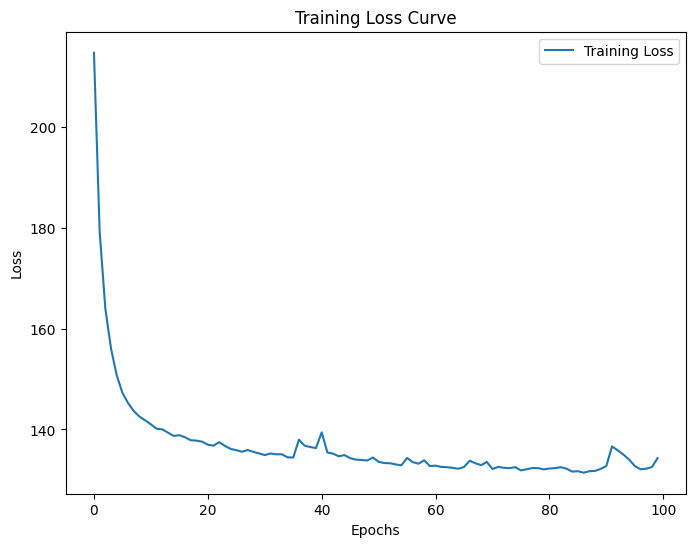

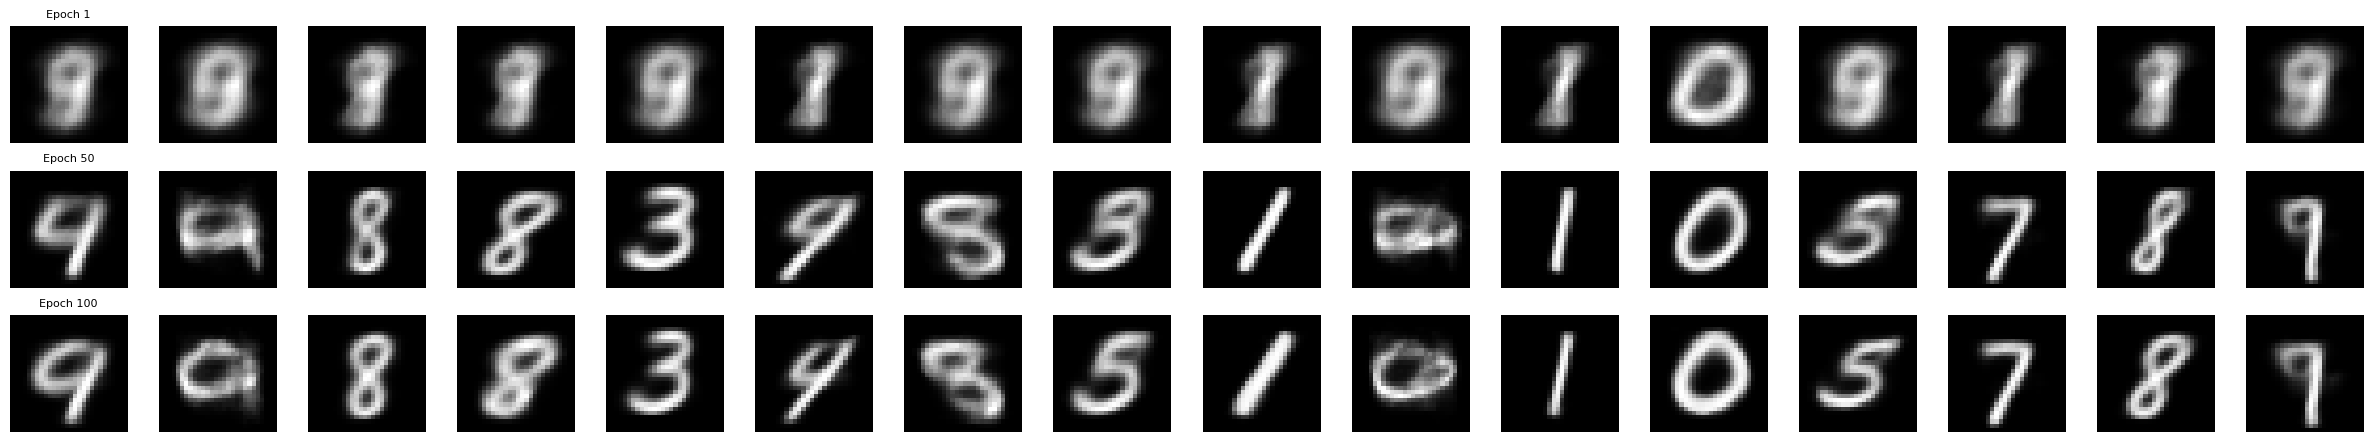

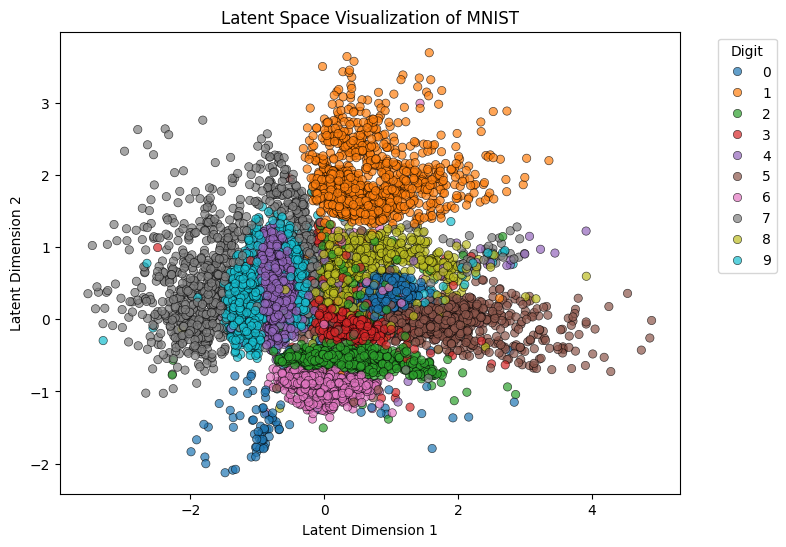

In [ ]:
# Main Execution
device = "cuda" if torch.cuda.is_available() else "cpu"
vae_model = VariationalAutoencoder(latent_size=2)

generated_images, training_loss, validation_loss = train_model(
    vae_model, train_dataloader, test_dataloader, num_epochs=100, learning_rate=1e-3, device=device
)

plot_loss_curve(training_loss)
plot_generated_images(generated_images)

latent_means, labels = get_latent_representations(vae_model, test_dataloader, device=device)
plot_latent_space(latent_means, labels)